(techniques:compositional_se)=
# Compositional Symbolic Execution

In [1]:
import utils
from minipy import *
from constraint_solving import *
from semantics import *
from symbolic_interpreter import *
from transparent_function_execution import *
from static_loops import *

Symbolic execution is a powerful program exploration technique, useful both in program verification, where SE overapproximates all feasible program paths, and test case generation, where SE steers the next program execution towards a yet uncovered path. In both application scenarios, however, it suffers from the *path explosion problem*: There are simply too many feasible program paths in large, realistic programs. This leads to immense symbolic execution trees in the case of static SE, and very long, complicated path conditions to be processed in the case of dynamic/concolic SE.

One solution to this problem is to render symbolic execution into a *compositional* analysis by analyzing not complete systems, but individual functions one at a time. This is accomplished by annotating functions with *summaries*, which conjoin "constraints on the function inputs observed during the exploration
of a path (...) with constraints observed on the outputs" {cite}`baldoni.coppa.ea-18`. Instead of symbolically executing a called function, we can use its *summary* to obtain the resulting symbolic state, which can dramatically reduce the overall search space.

Function summaries seem to have arisen independently in the areas of SE-based test generation and program verification. In the former area, Godefroid {cite}`godefroid-07` introduces the idea, building on existing similar principles form interprocedural static analysis (e.g., {cite}`reps.horwitz.ea-95`). As natural in automated test case generation, summaries are expected to be computed automatically; they are means for re-using previously discovered analysis results. In {cite}`anand.godefroid.ea-08`, the original idea of function summaries is extended to a demand-driven approach allowing lazy expansion of of incomplete summaries, which further improves the performance of the analysis.

For the area of program verification, we did not find an explicit reference to the first original work using function summaries for modular, static symbolic execution. However, function summaries are already mentioned as a means for modularization in the first paper reporting on the KeY project {cite}`ahrendt.baar.ea-00`, which appeared in 2000. Usually, function summaries are called "contract" in the verification context, inspired by the "design-by-contract" methodology {cite}`meyer-92`. Contracts are not only used for scalability, but additionally define the verification goals, i.e., the expected behavior, of functions in the program under test.

To support compositional symbolic execution, we extend our framework in two directions:

1. We add a convenience method to the symbolic interpreter which allows executing an individual function by its name, even without providing an initial symbolic environment.
2. We implement a new code transformer which replaces function calls by assertions of preconditions, `havoc` statements resetting the value of the variable to which the result of the function call is assigned, and assumptions of postconditions. This is similar to the transformation for SE with loop invariants described in {ref}`techniques:loops_static_se`, only that we do not verify that a function respect its contract when evaluating calls to that function. The verification can be done separately, for instance by suitably placed `assert` statements.

```{admonition} TODO
- Add both extensions describe above
- Introduce insertion sort example below
- Transform example, compositionally execute all functions. Maybe also non-compositionally to demonstrate how cumbersome this is.
```

In [2]:
class SymbolicInterpreter(SymbolicInterpreter):
    def execute_function_body(
            self,
            function_name: str,
            program: ASTNode,
            environment: Optional[SymbolicEnvironment] = None,
            loop_unrolling_threshold: Optional[int] = None):
        function_defs = FilterASTVisitor.filter(
            program,
            lambda n: isinstance(n, FunctionDef) and n.name == function_name)
        assert len(function_defs) == 1
        function_def: FunctionDef = next(iter(function_defs))
        variables = [Variable(param.name, get_type(param.type)) for param in function_def.params]

        new_environment = environment or SymbolicEnvironment()
        for variable in variables:
            if not new_environment.store.get_variable(variable.name):
                new_environment = new_environment.set(variable, variable.to_z3())

        return self.execute(function_def.block, new_environment, loop_unrolling_threshold)

In [3]:
class Contract:
    def __init__(
            self,
            precondition: Callable[[str, ...], str],
            postcondition: Callable[[str, ...], str],
            return_type: Type):
        self.precondition = precondition
        self.postcondition = postcondition
        self.return_type = return_type


class CompositionalSETransformer:
    def __init__(self, program: ASTNode, contracts: Dict[str, Contract]):
        self.contracts = contracts
        self.used_variables = UsedVariablesVisitor.get_used_variables(program)

    def __call__(self, *args, **kwargs):
        assert len(args) == 1
        assert not kwargs
        assert isinstance(args[0], ASTNode)
        node: ASTNode = args[0]

        if isinstance(node, Assignment):
            expression, contract_calls = self.process_expression(node.expression)
            if not contract_calls:
                return node
            return Stmts(contract_calls + [Assignment(node.lhs, expression)])
        elif isinstance(node, Assert):
            expression, contract_calls = self.process_expression(node.expression)
            if not contract_calls:
                return node
            return Stmts(contract_calls + [Assert(expression)])
        elif isinstance(node, ReturnStmt):
            expression, contract_calls = self.process_expression(node.expression)
            if not contract_calls:
                return node
            return Stmts(contract_calls + [ReturnStmt(expression)])
        elif isinstance(node, IfStmt):
            guard, contract_calls = self.process_expression(node.guard)
            if not contract_calls:
                return node
            return Stmts(contract_calls + [IfStmt(guard, node.then_block, node.else_block)])
        elif isinstance(node, WhileStmt):
            guard, contract_calls = self.process_expression(node.guard)
            if not contract_calls:
                return node
            return Stmts([
                WhileStmt(BooleanAtom(True), Block(
                    contract_calls + [
                        IfStmt(
                            guard,
                            node.body,
                            Block(
                                ([] if not node.else_block else node.else_block.stmts) +
                                [BreakStmt()]))
                    ]))
            ])

        return node

    def process_expression(self, expression: Expression) -> Tuple[Expression, List[ASTNode]]:
        call_transformer = ReplaceFunctionCallsTransformer(
            self.used_variables,
            {function_name for function_name in self.contracts.keys()}
        )
        expression = expression.transform(call_transformer)
        self.used_variables |= call_transformer.used_variables

        contract_calls: List[ASTNode] = list(itertools.chain(*[
            (
                contract := self.contracts[f_call.name],
                [
                    Assert(parse_expr(contract.precondition(*[arg.code for arg in f_call.args]))),
                    Assignment(variable, parse_expr(contract.return_type.default_literal)),
                    Havoc(variable),
                    Assume(parse_expr(contract.postcondition(*[arg.code for arg in f_call.args], variable))),
                ]
            )[-1]
            for variable, f_call in call_transformer.replacements.items()
        ]))

        return expression, contract_calls

In [4]:
def insertion_point(x: int, t: tuple) -> int:
    # assume Sorted(t)
    i = 0
    while i < len(t):
        if t[i] >= x:
            break

        i = i + 1

    return i


def insert(elem: int, at: int, t: tuple) -> tuple:
    # assume 0 <= at and at <= len(t)
    result = tuple()
    i = 0
    while i < at:
        result = result + (t[i],)
        i = i + 1

    result = result + (elem,)

    while i < len(t):
        result = result + (t[i],)
        i = i + 1

    return result


def sort(t: tuple) -> tuple:
    result = tuple()

    i = 0
    while i < len(t):
        elem = t[i]
        pos = insertion_point(elem, result)
        result = insert(elem, pos, result)
        i = i + 1

    return result

In [5]:
insertion_point(4, (-1, 3, 7, 9))

2

In [6]:
insert(4, 2, (-1, 3, 7, 9))

(-1, 3, 4, 7, 9)

In [7]:
insert(4, -1, (-1, 3, 7, 9))

(4, -1, 3, 7, 9)

In [8]:
sort((7, -1, 3, 9))

(-1, 3, 7, 9)

In [9]:
insertion_point_program = parse("""
def insertion_point(x: int, t: tuple) -> int:
    assume Sorted(t)
    i = 0
    while i < len(t):
        if t[i] >= x:
            break

        i = i + 1

    assert PostInsertionPoint(x, t, i)
    return i
""")

In [10]:
insert_program = parse("""
def insert(elem: int, at: int, t: tuple) -> tuple:
    assume 0 <= at and at <= len(t)

    result = tuple()
    i = 0
    while i < at:
        result = result + (t[i], )
        i = i + 1

    result = result + (elem, )

    while i < len(t):
        result = result + (t[i], )
        i = i + 1

    assert PostInsert(elem, at, t, result)
    return result
""")

Note: We do not show the permutation property of our algorithm (quite complex, goes beyond what we want to show in this section; e.g., in KeY book, special predicate defined for sequence permutations).

In [11]:
sort_program = parse("""
def sort(t: tuple) -> tuple:
    result = tuple()

    i = 0
    while i < len(t):
        elem = t[i]
        pos = insertion_point(elem, result)
        result = insert(elem, pos, result)
        i = i + 1

    assert Sorted(result) #and Permutation(t, result)
    return result
""")

In [12]:
full_program = Stmts([
    insertion_point_program,
    insert_program,
    sort_program
])

In [13]:
import z3

In [14]:
def display_formula(formula: z3.BoolRef) -> str:
    prev_html = z3.in_html_mode()
    z3.set_html_mode(True)

    result = (z3_html_escape(z3.obj_to_string(formula))
              .replace("\n", "<BR/>")
              .replace(" ", "&nbsp;")
             )

    z3.set_html_mode(prev_html)
    return display_html(result)

In [15]:
kv, lv = z3.Ints(["k", "l"])

In [16]:
sorted_prop = (
    lambda tv:
    z3.ForAll(
        [kv],
        z3.Implies(
            z3.And(
                kv >= z3.IntVal(0),
                kv < z3.Length(tv),
            ),
            z3.ForAll(
                [lv],
                z3.Implies(
                    z3.And(
                        lv > kv,
                        lv < z3.Length(tv)
                    ),
                    tv[kv] <= tv[lv]
                )))))

display_formula(sorted_prop(z3_sequence("t")))

In [17]:
valuev, kv = z3.Ints("value k")

contains_prop = (
    lambda t, valuev:
    z3.Exists(
        [kv],
        z3.And(
            kv >= z3.IntVal(0),
            kv < z3.Length(t),
            t[kv] == valuev
        )))

permutation_prop = (
    lambda t1, t2:
    z3.And(
        z3.Length(t1) == z3.Length(t2),
        z3.ForAll(
            [valuev],
            contains_prop(t1, valuev) ==
            contains_prop(t2, valuev)
        )))

permutation_prop(z3_sequence("t1"), z3_sequence("t2"))

And(Length(t1) == Length(t2),
    ForAll(value,
           (Exists(k,
                   And(0 <= k,
                       k < Length(t1),
                       Nth(t1, k) == value))) ==
           (Exists(k,
                   And(0 <= k,
                       k < Length(t2),
                       Nth(t2, k) == value)))))

In [18]:
insertion_point_invariant = (
    lambda xv, tv, iv:
        z3.And(
            iv >= z3.IntVal(0),
            iv <= z3.Length(tv),
            z3.ForAll(
                [kv],
                z3.Implies(
                    z3.And(
                        kv >= z3.IntVal(0),
                        kv < iv),
                    tv[kv] < xv
                )
            )))

display_formula(insertion_point_invariant(z3.Int("x"), z3_sequence("t"), z3.Int("i")))

In [19]:
post_insertion_point = (
    lambda xv, tv, resultv:
    z3.And(                
        z3.IntVal(0) <= resultv,
        resultv <= z3.Length(tv),
        z3.ForAll(
            [kv],
            z3.Implies(
                z3.And(
                    kv >= z3.IntVal(0),
                    kv < resultv),
                tv[kv] < xv
            )
        ),
        z3.ForAll(
            [kv],
            z3.Implies(
                z3.And(
                    kv >= resultv,
                    kv < z3.Length(tv)),
                tv[kv] >= xv
            )
        )))

display_formula(post_insertion_point(z3.Int("x"), z3_sequence("t"), z3.Int("result")))

In [20]:
insertion_point_loop = next(iter(
    FilterASTVisitor.filter(insertion_point_program, lambda node: isinstance(node, WhileStmt))))
loop_scope_transformer = LoopScopeTransformer({insertion_point_loop: parse_expr("InsertionPointInv(x, t, i)")})
insertion_point_loop_scopes = insertion_point_program.transform(loop_scope_transformer)
display_program(insertion_point_loop_scopes.code)

```python
def insertion_point(x: int, t: tuple) -> int:
    assume Sorted(t)
    i = 0
    assert InsertionPointInv(x, t, i)
    havoc i
    assume InsertionPointInv(x, t, i)
    loop-scope(inv=InsertionPointInv(x, t, i)):
        if (i < len(t)):
            if (t[i] >= x):
                break
            i = (i + 1)
            continue
        else:
            break
    assert PostInsertionPoint(x, t, i)
    return i
```

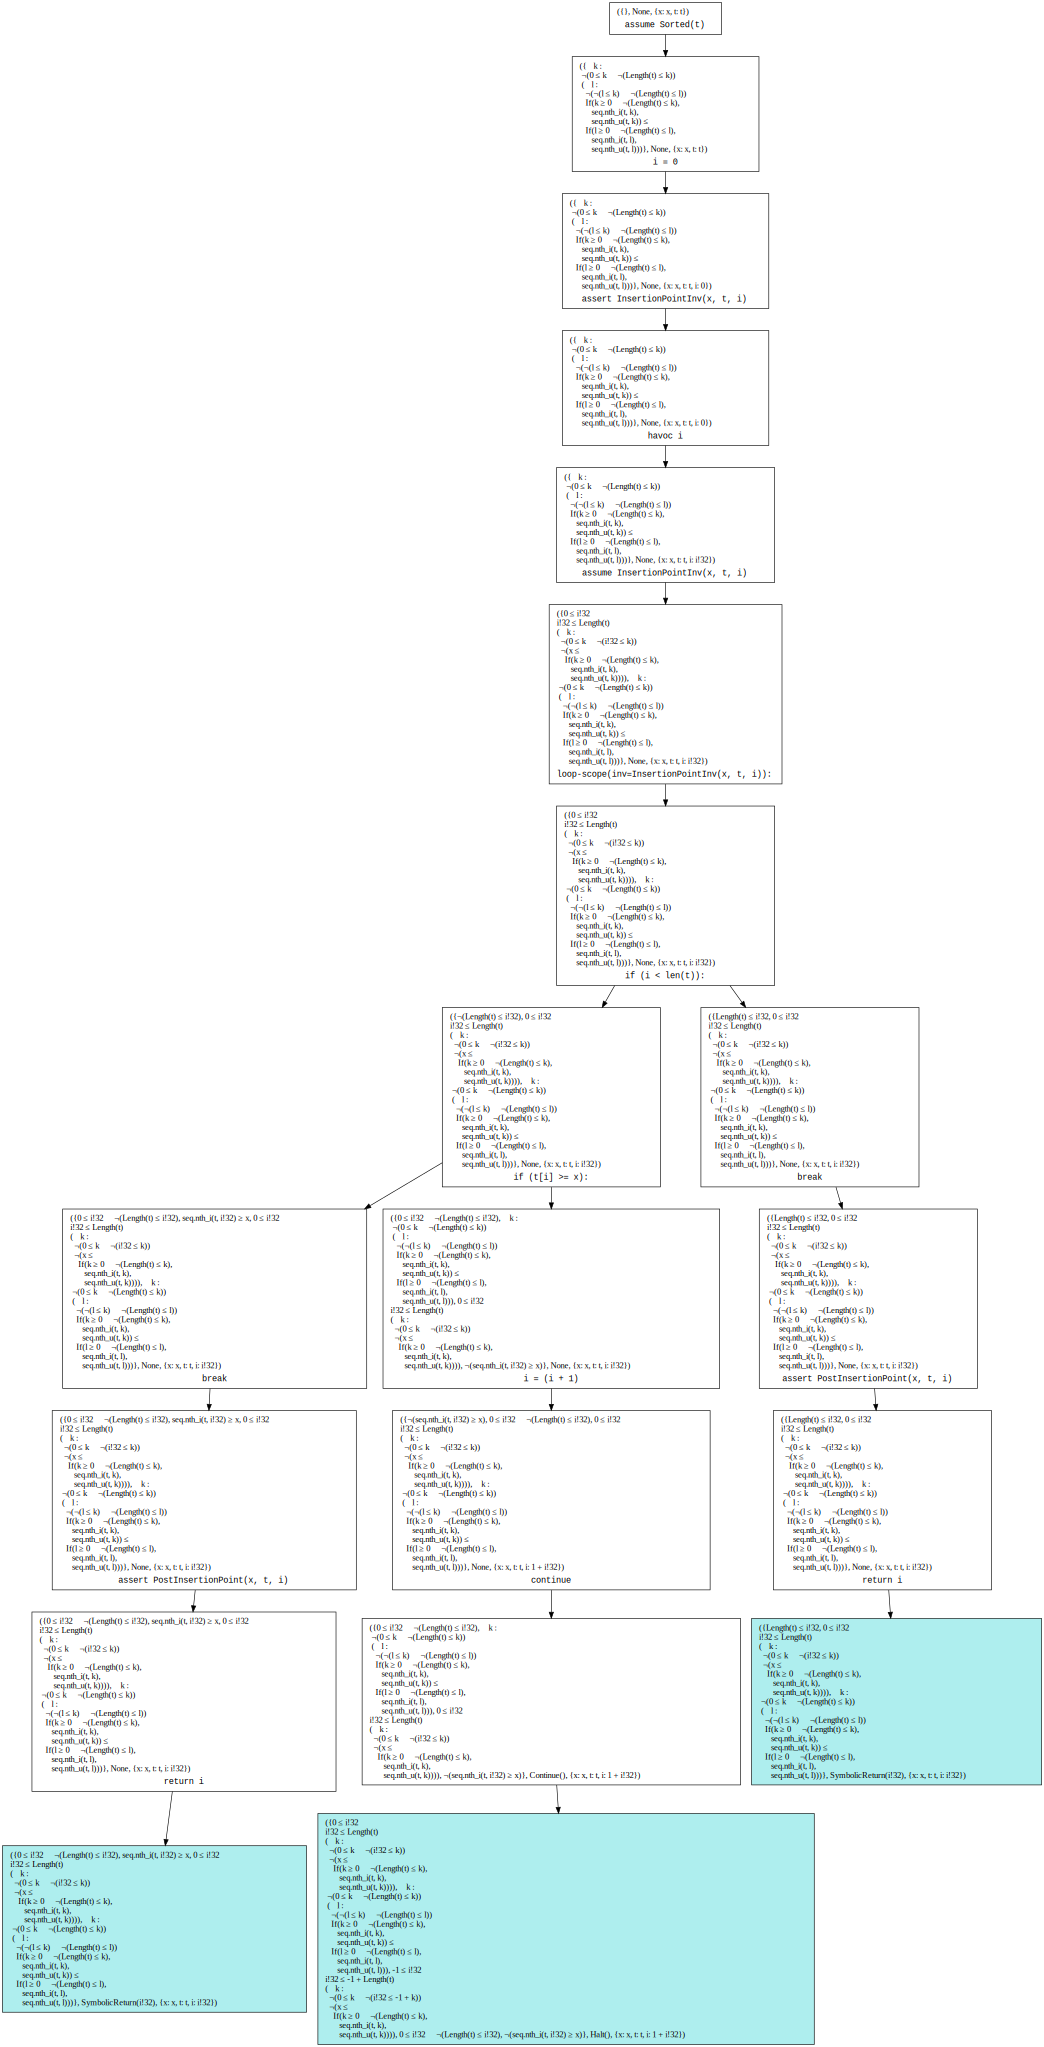

In [21]:
interpreter = SymbolicInterpreter(predicates={
    "Sorted": ((z3.SeqSort(z3.IntSort()),), z3.BoolSort(), sorted_prop),
    "InsertionPointInv": ((z3.IntSort(), z3.SeqSort(z3.IntSort()), z3.IntSort()), z3.BoolSort(), insertion_point_invariant),
    "PostInsertionPoint": ((z3.IntSort(), z3.SeqSort(z3.IntSort()), z3.IntSort()), z3.BoolSort(), post_insertion_point),
    "len": ((z3.SeqSort(z3.IntSort()),), z3.IntSort(), z3.Length)
})

insertion_point_set = interpreter.execute_function_body("insertion_point", insertion_point_loop_scopes)
display_set(insertion_point_set)

In [22]:
post_insert = (
    lambda elemv, atv, tv, resultv:
    resultv == z3.Concat(
        z3.SubSeq(tv, z3.IntVal(0), atv),
        z3.Unit(elemv),
        z3.SubSeq(tv, atv, z3.Length(tv) - atv)
    )
)

display_formula(post_insert(z3.Int("elem"), z3.Int("at"), z3_sequence("t"), z3_sequence("result")))

In [23]:
insert_invariant_1 = (
    lambda iv, elemv, atv, tv, resultv:
    z3.And(
        iv >= z3.IntVal(0),
        iv <= atv,
        resultv == z3.SubSeq(tv, z3.IntVal(0), iv),
    )
)

display_formula(insert_invariant_1(z3.Int("i"), z3.Int("elem"), z3.Int("at"), z3_sequence("t"), z3_sequence("result")))

In [24]:
insert_invariant_2 = (
    lambda iv, elemv, atv, tv, resultv:
    z3.And(
        iv >= atv,
        iv <= z3.Length(tv),
        resultv == z3.Concat(
            z3.SubSeq(tv, z3.IntVal(0), atv),
            z3.Unit(elemv),
            z3.SubSeq(tv, atv, iv - atv)
        )
    )
)

display_formula(insert_invariant_2(z3.Int("i"), z3.Int("elem"), z3.Int("at"), z3_sequence("t"), z3_sequence("result")))

In [25]:
insert_loops = list(FilterASTVisitor.filter(insert_program, lambda node: isinstance(node, WhileStmt)))

insert_loop_1 = insert_loops[0]
insert_loop_2 = insert_loops[1]


loop_scope_transformer = LoopScopeTransformer({
    insert_loop_1: parse_expr("InsertInvariant1(i, elem, at, t, result)"),
    insert_loop_2: parse_expr("InsertInvariant2(i, elem, at, t, result)")
})
insert_loop_scopes = insert_program.transform(loop_scope_transformer)
display_program(insert_loop_scopes.code)

```python
def insert(elem: int, at: int, t: tuple) -> tuple:
    assume ((0 <= at) and (at <= len(t)))
    result = tuple()
    i = 0
    assert InsertInvariant1(i, elem, at, t, result)
    havoc result
    havoc i
    assume InsertInvariant1(i, elem, at, t, result)
    loop-scope(inv=InsertInvariant1(i, elem, at, t, result)):
        if (i < at):
            result = (result + (t[i], ))
            i = (i + 1)
            continue
        else:
            break
    result = (result + (elem, ))
    assert InsertInvariant2(i, elem, at, t, result)
    havoc result
    havoc i
    assume InsertInvariant2(i, elem, at, t, result)
    loop-scope(inv=InsertInvariant2(i, elem, at, t, result)):
        if (i < len(t)):
            result = (result + (t[i], ))
            i = (i + 1)
            continue
        else:
            break
    assert PostInsert(elem, at, t, result)
    return result
```

In [26]:
logging.basicConfig(level=logging.ERROR)

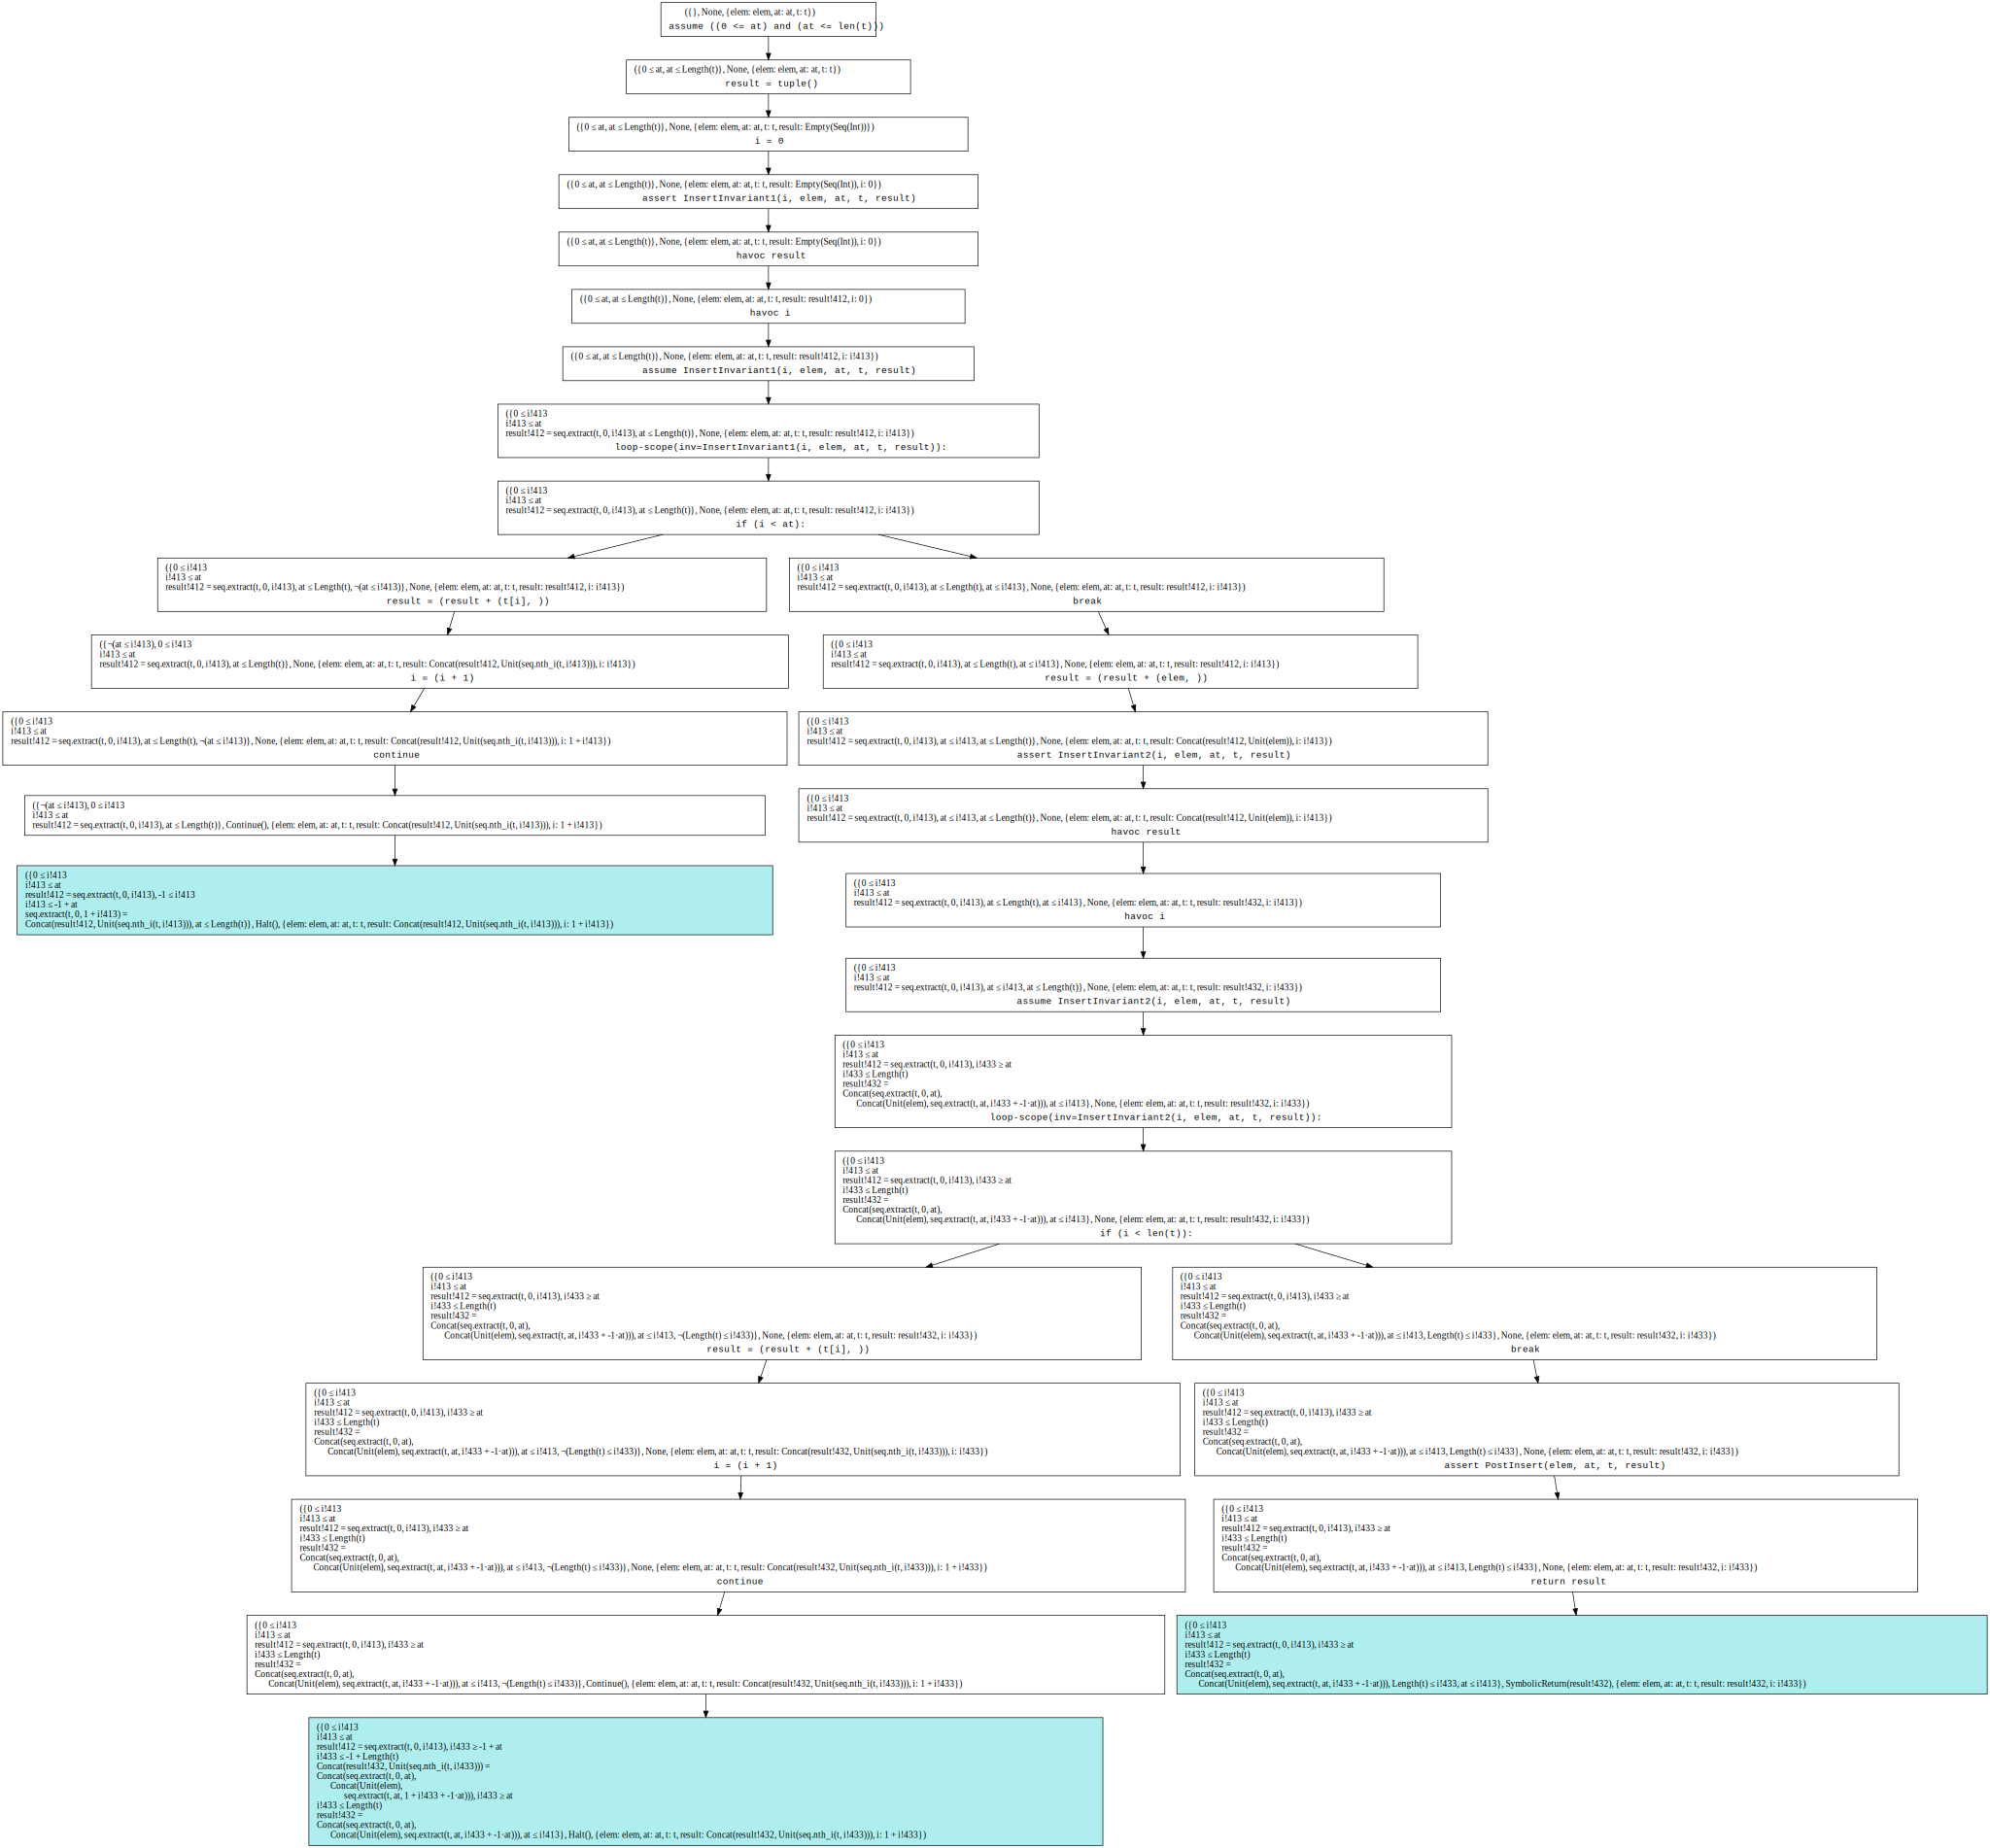

In [27]:
interpreter = SymbolicInterpreter(predicates={
    "PostInsert": (
        (z3.IntSort(), z3.IntSort(), z3.SeqSort(z3.IntSort()), z3.SeqSort(z3.IntSort())), z3.BoolSort(),
        post_insert),
    "InsertInvariant1": (
        (z3.IntSort(), z3.IntSort(), z3.IntSort(), z3.SeqSort(z3.IntSort()), z3.SeqSort(z3.IntSort())),
        z3.BoolSort(), insert_invariant_1),
    "InsertInvariant2": (
        (z3.IntSort(), z3.IntSort(), z3.IntSort(), z3.SeqSort(z3.IntSort()), z3.SeqSort(z3.IntSort())),
        z3.BoolSort(), insert_invariant_2),
    "len": ((z3.SeqSort(z3.IntSort()),), z3.IntSort(), z3.Length)
})

insert_set = interpreter.execute_function_body("insert", insert_loop_scopes)
display_set(insert_set)

In [28]:
sort_invariant = (
    lambda iv, tv, resultv:
    z3.And(
        iv >= z3.IntVal(0),
        iv <= z3.Length(tv),
        z3.Length(resultv) == iv,
        sorted_prop(resultv),
        #permutation_prop(resultv, z3.SubSeq(tv, z3.IntVal(0), iv))
    )
)

display_formula(sort_invariant(z3.Int("i"), z3_sequence("t"), z3_sequence("result")))

In [29]:
sort_loop = next(iter(
    FilterASTVisitor.filter(sort_program, lambda node: isinstance(node, WhileStmt))))
loop_scope_transformer = LoopScopeTransformer({sort_loop: parse_expr("SortInv(i, t, result)")})
sort_loop_scopes = sort_program.transform(loop_scope_transformer)
display_program(sort_loop_scopes.code)

```python
def sort(t: tuple) -> tuple:
    result = tuple()
    i = 0
    assert SortInv(i, t, result)
    havoc result
    havoc pos
    havoc i
    havoc elem
    assume SortInv(i, t, result)
    loop-scope(inv=SortInv(i, t, result)):
        if (i < len(t)):
            elem = t[i]
            pos = insertion_point(elem, result)
            result = insert(elem, pos, result)
            i = (i + 1)
            continue
        else:
            break
    assert Sorted(result)
    return result
```

In [30]:
insertion_point_contract = Contract(
    precondition=lambda x, t: f"Sorted({t})",
    postcondition=lambda x, t, result: f"PostInsertionPoint({x}, {t}, {result})",
    return_type=INT_TYPE
)

insert_contract = Contract(
    precondition=lambda elem, at, t: f"0 <= {at} and {at} <= len({t})",
    postcondition=lambda elem, at, t, result: f"PostInsert({elem}, {at}, {t}, {result})",
    return_type=TUPLE_TYPE
)

In [31]:
compositional_transformer = CompositionalSETransformer(
    sort_loop_scopes,
    {
        "insertion_point": insertion_point_contract,
        "insert": insert_contract
    })
sort_compositional = sort_loop_scopes.transform(compositional_transformer)

display_program(sort_compositional.code)

```python
def sort(t: tuple) -> tuple:
    result = tuple()
    i = 0
    assert SortInv(i, t, result)
    havoc result
    havoc pos
    havoc i
    havoc elem
    assume SortInv(i, t, result)
    loop-scope(inv=SortInv(i, t, result)):
        if (i < len(t)):
            elem = t[i]
            assert Sorted(result)
            var_0 = 0
            havoc var_0
            assume PostInsertionPoint(elem, result, var_0)
            pos = var_0
            assert ((0 <= pos) and (pos <= len(result)))
            var_1 = tuple()
            havoc var_1
            assume PostInsert(elem, pos, result, var_1)
            result = var_1
            i = (i + 1)
            continue
        else:
            break
    assert Sorted(result)
    return result
```

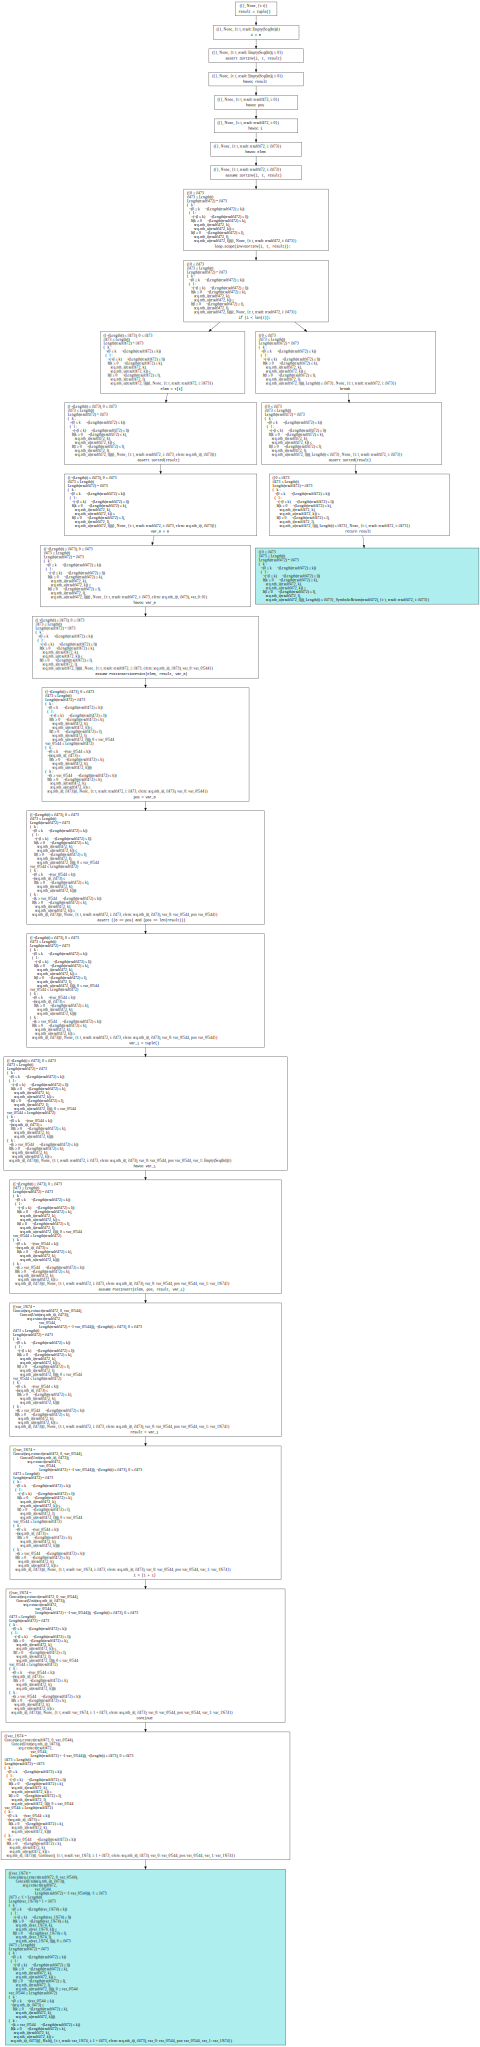

In [32]:
interpreter = SymbolicInterpreter(predicates={
    "SortInv": ((z3.IntSort(), z3.SeqSort(z3.IntSort()), z3.SeqSort(z3.IntSort())), z3.BoolSort(), sort_invariant),
    "Sorted": ((z3.SeqSort(z3.IntSort()),), z3.BoolSort(), sorted_prop),
    #"Permutation": ((z3.SeqSort(z3.IntSort()), z3.SeqSort(z3.IntSort())), z3.BoolSort(), permutation_prop),
    "PostInsertionPoint": ((z3.IntSort(), z3.SeqSort(z3.IntSort()), z3.IntSort()), z3.BoolSort(), post_insertion_point),
    "PostInsert": (
        (z3.IntSort(), z3.IntSort(), z3.SeqSort(z3.IntSort()), z3.SeqSort(z3.IntSort())), z3.BoolSort(),
        post_insert),
    "len": ((z3.SeqSort(z3.IntSort()),), z3.IntSort(), z3.Length)
})

sort_set = interpreter.execute_function_body("sort", sort_compositional)
display_set(sort_set)

## References

```{bibliography}
:filter: docname in docnames
```